In [82]:
import kagglehub
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,normalize,OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score,recall_score,confusion_matrix,roc_curve,auc
from sklearn.model_selection import train_test_split,cross_val_score
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

In [83]:
path = kagglehub.dataset_download("uom190346a/global-coffee-health-dataset")
df = pd.read_csv("synthetic_coffee_health_10000.csv")
print(df)

         ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0         1   40    Male  Germany            3.5        328.1          7.5   
1         2   33    Male  Germany            1.0         94.1          6.2   
2         3   42    Male   Brazil            5.3        503.7          5.9   
3         4   53    Male  Germany            2.6        249.2          7.3   
4         5   32  Female    Spain            3.1        298.0          5.3   
...     ...  ...     ...      ...            ...          ...          ...   
9995   9996   50  Female    Japan            2.1        199.8          6.0   
9996   9997   18  Female       UK            3.4        319.2          5.8   
9997   9998   26    Male    China            1.6        153.4          7.1   
9998   9999   40  Female  Finland            3.4        327.1          7.0   
9999  10000   42  Female   Brazil            2.9        277.5          6.4   

     Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Act

In [84]:
df.describe()

ID           Age  Coffee_Intake   Caffeine_mg   Sleep_Hours  \
count  10000.00000  10000.000000   10000.000000  10000.000000  10000.000000   
mean    5000.50000     34.949100       2.509230    238.411010      6.636220   
std     2886.89568     11.160939       1.450248    137.748815      1.222055   
min        1.00000     18.000000       0.000000      0.000000      3.000000   
25%     2500.75000     26.000000       1.500000    138.750000      5.800000   
50%     5000.50000     34.000000       2.500000    235.400000      6.600000   
75%     7500.25000     43.000000       3.500000    332.025000      7.500000   
max    10000.00000     80.000000       8.200000    780.300000     10.000000   

                BMI    Heart_Rate  Physical_Activity_Hours      Smoking  \
count  10000.000000  10000.000000              10000.00000  10000.00000   
mean      23.986860     70.617800                  7.48704      0.20040   
std        3.906411      9.822951                  4.31518      0.40032   
min       15.000000     50.000000                  0.00000      0.00000   
25%       21.300000     64.000000                  3.70000      0.00000   
50%       24.000000     71.000000                  7.50000      0.00000   
75%       26.600000     77.000000                 11.20000      0.00000   
max       38.200000    109.000000                 15.00000      1.00000   

       Alcohol_Consumption  
count         10000.000000  
mean              0.300700  
std               0.458585  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               1.000000  
max               1.000000

In [85]:
numeric_cols = df.select_dtypes(include='number').columns
df_numeric = df.groupby("Country", as_index=False)[numeric_cols].mean()
df_stress = df.groupby("Country", as_index=False)["Stress_Level"].agg(lambda x: x.mode()[0])
df_grouped = pd.merge(df_numeric, df_stress, on="Country")

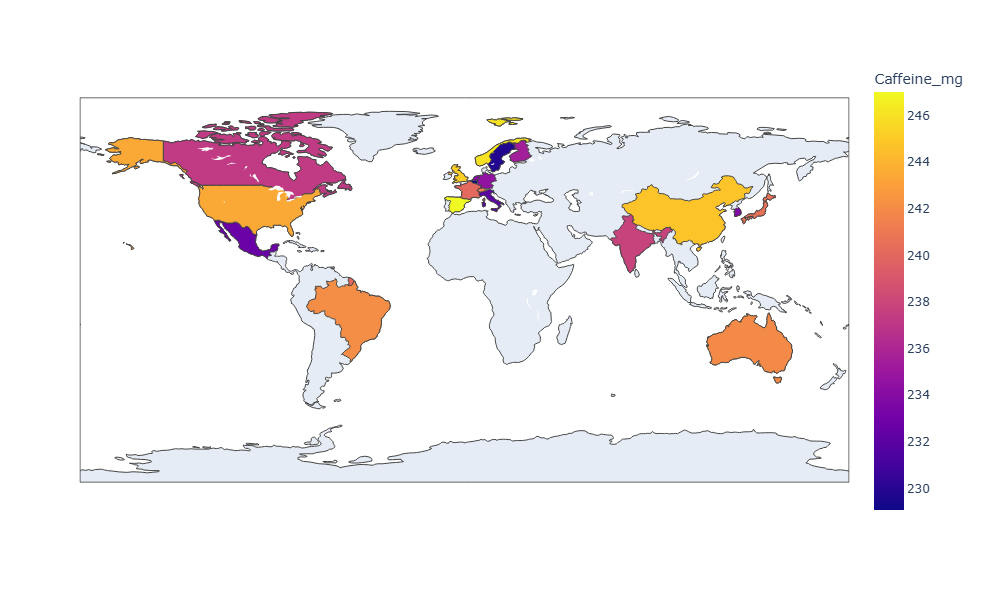

In [86]:

fig = px.choropleth(
    df_grouped,
    locations="Country",
    locationmode="country names",
    color="Caffeine_mg",
    hover_name="Country",
    hover_data=["Coffee_Intake", "Sleep_Hours", "Stress_Level"],
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.update_layout(
    width=1000,
    height=600
)
fig.show()

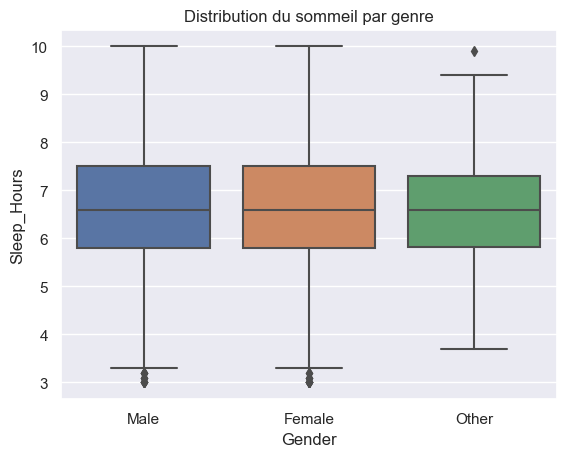

In [87]:
sns.boxplot(data=df, x='Gender', y='Sleep_Hours')
plt.title("Distribution du sommeil par genre")
plt.show()

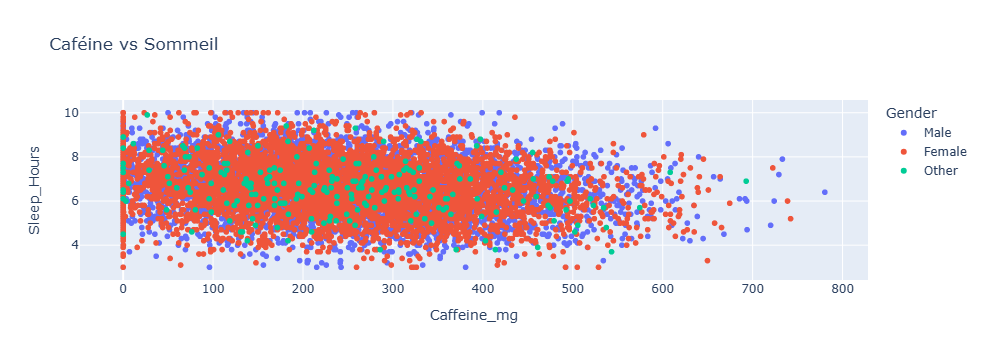

In [88]:
fig = px.scatter(
    df,
    x='Caffeine_mg',
    y='Sleep_Hours',
    color='Gender',
    hover_data=['Country', 'Occupation'],
    title='Caféine vs Sommeil'
)
fig.show()

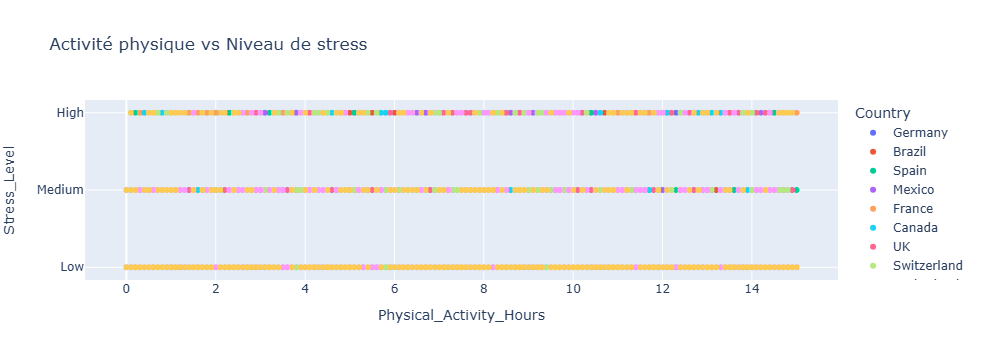

In [89]:
fig = px.scatter(
    df,
    x='Physical_Activity_Hours',
    y='Stress_Level',
    color='Country',
    hover_data=['Gender', 'Occupation'],
    title='Activité physique vs Niveau de stress'
)
fig.show()

In [90]:
df["Sleep_Quality"] = df["Sleep_Quality"].replace({"Good":2,"Poor":0,"Fair":1,"Excellent":3})
df["Stress_Level"] = df["Stress_Level"].replace({"Low":0,"Medium":1,"High":2})
df["Occupation"].unique()
df["Occupation"] = df["Occupation"].replace({"Student":0,"Healthcare":1,"Office":2,"Service":3,"Other":4})
df["Gender"] = df["Gender"].replace({"Male":1,"Female":0,"Other":2})
df["Health_Issues"] = df["Health_Issues"].fillna("None")
df["Health_Issues"] = df["Health_Issues"].replace({"None":0,"Mild":1,"Moderate":2,"Severe":3})

df = df.drop(columns="ID")
df = df.drop(columns="Country")
df

Age  Gender  Coffee_Intake  Caffeine_mg  Sleep_Hours  Sleep_Quality  \
0      40       1            3.5        328.1          7.5              2   
1      33       1            1.0         94.1          6.2              2   
2      42       1            5.3        503.7          5.9              1   
3      53       1            2.6        249.2          7.3              2   
4      32       0            3.1        298.0          5.3              1   
...   ...     ...            ...          ...          ...            ...   
9995   50       0            2.1        199.8          6.0              1   
9996   18       0            3.4        319.2          5.8              1   
9997   26       1            1.6        153.4          7.1              2   
9998   40       0            3.4        327.1          7.0              2   
9999   42       0            2.9        277.5          6.4              2   

       BMI  Heart_Rate  Stress_Level  Physical_Activity_Hours  Health_Issues  \
0     24.9          78             0                     14.5              0   
1     20.0          67             0                     11.0              0   
2     22.7          59             1                     11.2              1   
3     24.7          71             0                      6.6              1   
4     24.1          76             1                      8.5              1   
...    ...         ...           ...                      ...            ...   
9995  30.5          50             1                     10.1              2   
9996  19.1          71             1                     11.6              1   
9997  25.1          66             0                     13.7              0   
9998  19.3          80             0                      0.1              0   
9999  28.1          72             0                      9.8              0   

      Occupation  Smoking  Alcohol_Consumption  
0              4        0                    0  
1              3        0                    0  
2              2        0                    0  
3              4        0                    0  
4              0        0                    1  
...          ...      ...                  ...  
9995           1        0                    1  
9996           3        0                    0  
9997           0        1                    1  
9998           0        0                    0  
9999           0        1                    0  

[10000 rows x 14 columns]

In [91]:
num_col = ["Coffee_Intake","Caffeine_mg","Sleep_Hours","Sleep_Quality",
           "BMI","Heart_Rate","Health_Issues","Stress_Level","Physical_Activity_Hours",
           "Occupation","Smoking","Alcohol_Consumption"]
df_col = df[num_col]
df_col

Coffee_Intake  Caffeine_mg  Sleep_Hours  Sleep_Quality   BMI  \
0               3.5        328.1          7.5              2  24.9   
1               1.0         94.1          6.2              2  20.0   
2               5.3        503.7          5.9              1  22.7   
3               2.6        249.2          7.3              2  24.7   
4               3.1        298.0          5.3              1  24.1   
...             ...          ...          ...            ...   ...   
9995            2.1        199.8          6.0              1  30.5   
9996            3.4        319.2          5.8              1  19.1   
9997            1.6        153.4          7.1              2  25.1   
9998            3.4        327.1          7.0              2  19.3   
9999            2.9        277.5          6.4              2  28.1   

      Heart_Rate  Health_Issues  Stress_Level  Physical_Activity_Hours  \
0             78              0             0                     14.5   
1             67              0             0                     11.0   
2             59              1             1                     11.2   
3             71              1             0                      6.6   
4             76              1             1                      8.5   
...          ...            ...           ...                      ...   
9995          50              2             1                     10.1   
9996          71              1             1                     11.6   
9997          66              0             0                     13.7   
9998          80              0             0                      0.1   
9999          72              0             0                      9.8   

      Occupation  Smoking  Alcohol_Consumption  
0              4        0                    0  
1              3        0                    0  
2              2        0                    0  
3              4        0                    0  
4              0        0                    1  
...          ...      ...                  ...  
9995           1        0                    1  
9996           3        0                    0  
9997           0        1                    1  
9998           0        0                    0  
9999           0        1                    0  

[10000 rows x 12 columns]

In [92]:
from scipy.stats import kruskal
p_val = []
for col in num_col :
    h, pval = kruskal(df[col][df["Stress_Level"]==0],df[col][df["Stress_Level"]==1],df[col][df["Stress_Level"]==2])
    p_val.append(pval)
    
niveau = []

for pval in p_val:
    if pval <0.05:
        niveau.append("Oui")
    else:
        niveau.append("Non")
        
res = pd.DataFrame({"Variable":num_col,"P-value":p_val,"Significativité":niveau})
res.set_index("Variable",inplace=True)
print(res)

                              P-value Significativité
Variable                                             
Coffee_Intake            7.348904e-49             Oui
Caffeine_mg              6.425906e-49             Oui
Sleep_Hours              0.000000e+00             Oui
Sleep_Quality            0.000000e+00             Oui
BMI                      9.398763e-01             Non
Heart_Rate               3.343650e-03             Oui
Health_Issues            0.000000e+00             Oui
Stress_Level             0.000000e+00             Oui
Physical_Activity_Hours  5.403145e-01             Non
Occupation               6.916460e-02             Non
Smoking                  4.178634e-01             Non
Alcohol_Consumption      4.446936e-01             Non


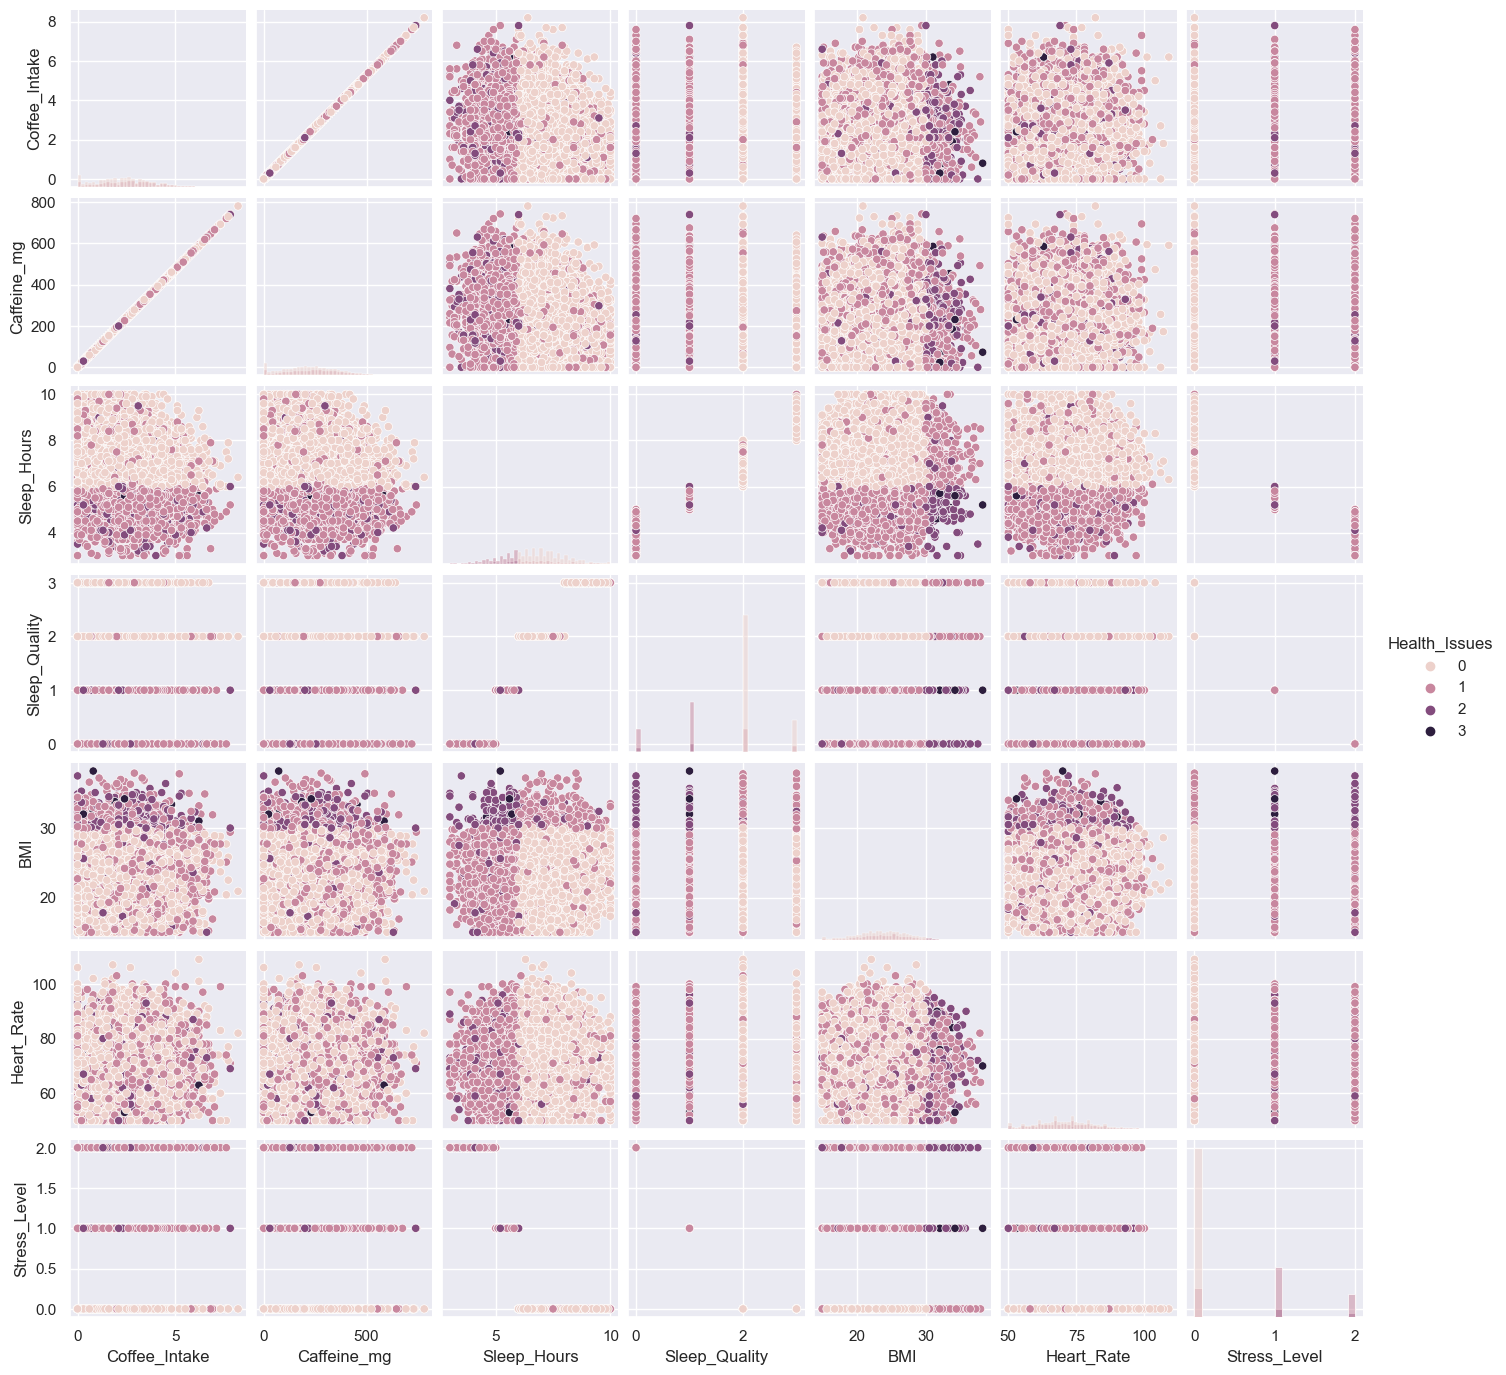

In [15]:
num_col2 = ["Coffee_Intake","Caffeine_mg","Sleep_Hours","Sleep_Quality",
           "BMI","Heart_Rate","Stress_Level","Health_Issues"]
df_col2 = df[num_col2]
sns.pairplot(data=df_col2,hue="Health_Issues",diag_kind="hist",height = 2)
plt.savefig("pairplot.png", dpi=120)

<Axes: >

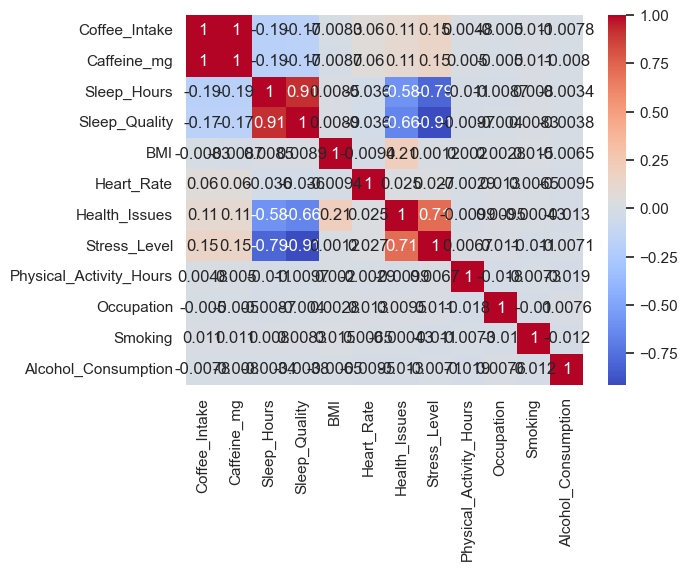

In [93]:
from sklearn.preprocessing import label_binarize
sns.heatmap(df_col.corr(),cmap = "coolwarm",annot =True)

In [94]:
from scipy.stats import spearmanr
num_col = ["Coffee_Intake","Caffeine_mg","Sleep_Hours","Sleep_Quality",
           "BMI","Heart_Rate","Health_Issues","Stress_Level","Physical_Activity_Hours",
           "Occupation","Smoking","Alcohol_Consumption"]
df_col = df[num_col]

for i in range(len(num_col)):
    coef, p_value = spearmanr(df["Health_Issues"],df[num_col[i]])
    print("Coefficient de Spearman sur",num_col[i],":", coef)
    print("p-value sur",num_col[i],":", p_value)

Coefficient de Spearman sur Coffee_Intake : 0.10935253846668022
p-value sur Coffee_Intake : 5.519894840194288e-28
Coefficient de Spearman sur Caffeine_mg : 0.10950864519700726
p-value sur Caffeine_mg : 4.63710734985166e-28
Coefficient de Spearman sur Sleep_Hours : -0.6283716540600789
p-value sur Sleep_Hours : 0.0
Coefficient de Spearman sur Sleep_Quality : -0.7001972176040713
p-value sur Sleep_Quality : 0.0
Coefficient de Spearman sur BMI : 0.14974110260381895
p-value sur BMI : 3.0961386745138507e-51
Coefficient de Spearman sur Heart_Rate : 0.0221568216824754
p-value sur Heart_Rate : 0.026713619811707782
Coefficient de Spearman sur Health_Issues : 1.0
p-value sur Health_Issues : 0.0
Coefficient de Spearman sur Stress_Level : 0.7869425809822825
p-value sur Stress_Level : 0.0
Coefficient de Spearman sur Physical_Activity_Hours : -0.00851609168044674
p-value sur Physical_Activity_Hours : 0.3944815853767575
Coefficient de Spearman sur Occupation : 0.010117102781160365
p-value sur Occupatio

In [95]:
#Isolement de la variable cible
X = df_col.drop("Health_Issues",axis=1)
y = df_col["Health_Issues"]

In [96]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [97]:
#Création du Pipeline chargeant les inputs
cat_cols = X.select_dtypes(include="object").columns.tolist()
pre_processeur = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")


pipeline = Pipeline([("prep", pre_processeur),("clf", RandomForestClassifier(oob_score=True, random_state=42))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('clf',
                 RandomForestClassifier(oob_score=True, random_state=42))])

In [98]:
#Prédiction de la variable cible
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
y_train_proba = pipeline.predict_proba(X_train)
y_test_proba = pipeline.predict_proba(X_test)

In [99]:
#Efficacité sur la proba de prédiction
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_rec = recall_score(y_train, y_train_pred, average='macro')
test_rec = recall_score(y_test, y_test_pred, average='macro')
train_roc = roc_auc_score(y_train, y_train_proba, multi_class='ovr')
test_roc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')

In [100]:
print(f"Accuracy: {test_acc:.3f}")
print(f"Recall: {test_rec:.3f}")
print(f"AUC: {test_roc:.3f}")

Accuracy: 0.903
Recall: 0.545
AUC: 0.921


In [101]:
#Distribution des classes, Domination/Minoration
pd.Series(y_train).value_counts(normalize=True)
pd.Series(y_test).value_counts(normalize=True)

0    0.6090
1    0.3470
2    0.0415
3    0.0025
Name: Health_Issues, dtype: float64

In [102]:
np.unique(y_test_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([1347,  617,   36], dtype=int64))

In [103]:
classes = np.unique(y_train)
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

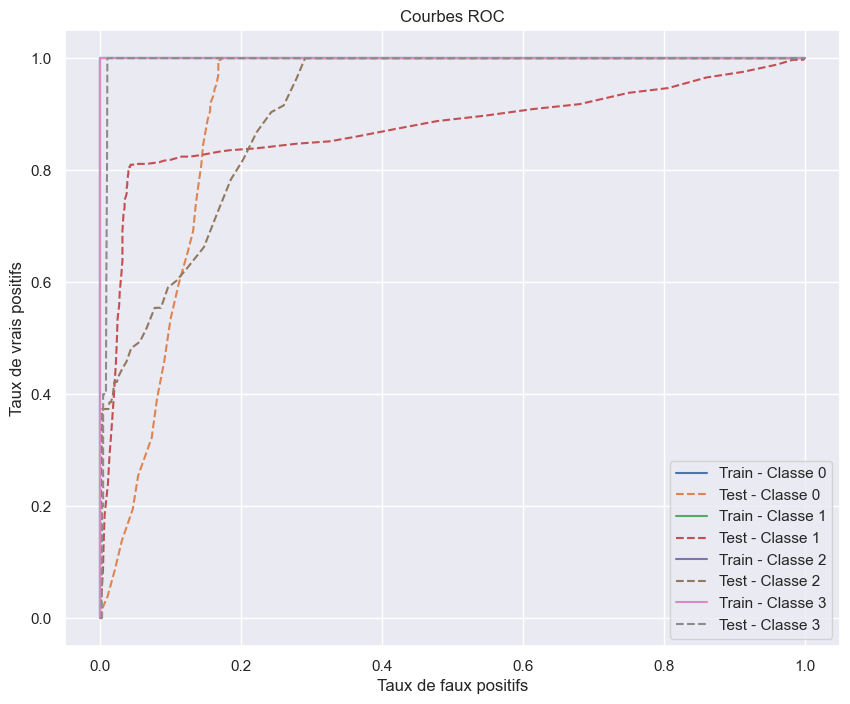

In [104]:
#Faux/Vrais positifs courbe ROC
plt.figure(figsize=(10,8))
for i,classe in enumerate(classes):
    fpr_train,tpr_train,_ = roc_curve(y_train_bin[:, i], y_train_proba[:, i])
    fpr_test,tpr_test,_ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_train, tpr_train, label=f"Train - Classe {classe}")
    plt.plot(fpr_test, tpr_test, linestyle='--', label=f"Test - Classe {classe}")
plt.title("Courbes ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [105]:
from sklearn.metrics import precision_score,f1_score,ConfusionMatrixDisplay,balanced_accuracy_score

train_prec = precision_score(y_train, y_train_pred, average='macro')
test_prec = precision_score(y_test, y_test_pred, average='macro')

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

train_bal_acc = balanced_accuracy_score(y_train, y_train_pred)
test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)

In [106]:
print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.901     0.997     0.947      1218
           1      0.909     0.808     0.856       694
           2      0.861     0.373     0.521        83
           3      0.000     0.000     0.000         5

    accuracy                          0.903      2000
   macro avg      0.668     0.545     0.581      2000
weighted avg      0.900     0.903     0.895      2000



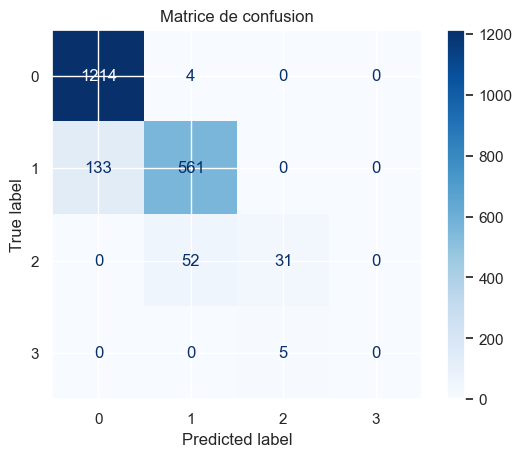

In [107]:
# Matrice de Confusion
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()

In [108]:
print(f"\nPrecision :{test_prec:.3f}")
print(f"F1-score : {test_f1:.3f}")
print(f"Balanced Accuracy : {test_bal_acc:.3f}")


Precision :0.668
F1-score : 0.581
Balanced Accuracy : 0.545


In [109]:
# Perte des prédictions
from sklearn.metrics import log_loss
pipeline.fit(X_train, y_train)
y_proba = pipeline.predict_proba(X_test)
loss = log_loss(y_test, y_proba)
print("CCE log-loss:", loss)

CCE log-loss: 0.3800876777924635


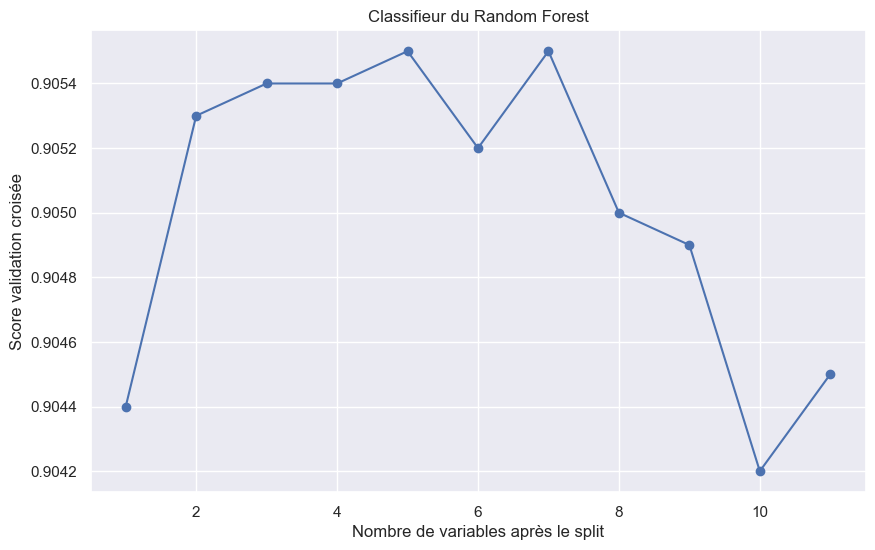

In [53]:
from sklearn.compose import ColumnTransformer
nb_directions = np.arange(1, X.shape[1]+1, 1)
cv_scores = []

# A chaque split on affine les prédictions par "vote majoritaire"
for param in nb_directions:
    pipeline = Pipeline([
        ("prep", pre_processeur),
        ("clf", RandomForestClassifier(max_features=param, random_state=42))])
    scores = cross_val_score(pipeline,X,y,cv=5,scoring='accuracy')
    cv_scores.append(np.mean(scores))

plt.figure(figsize=(10, 6))
plt.plot(nb_directions, cv_scores, marker='o')
plt.xlabel("Nombre de variables après le split")
plt.ylabel("Score validation croisée")
plt.title("Classifieur du Random Forest")
plt.grid(True)
plt.show()

In [54]:
# La meilleure profondeur pour le score maximum
meilleur = nb_directions[np.argmax(cv_scores)]

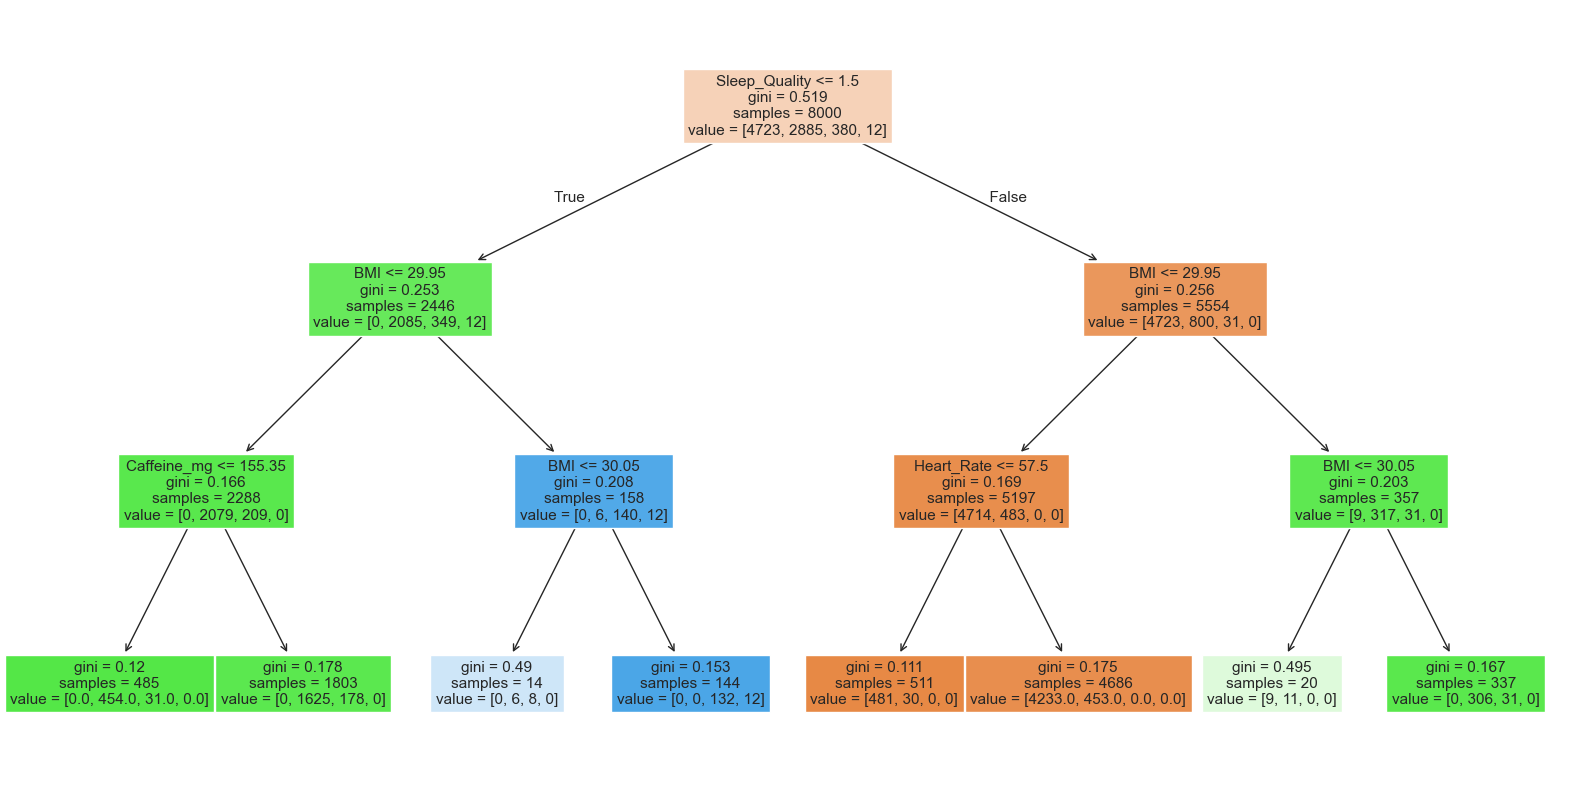

In [55]:
# Classifieur de l'arbre de décision
arbre = DecisionTreeClassifier(max_depth=meilleur-2,random_state=42)
arbre.fit(X_train,y_train)

plt.figure(figsize=(20,10))
plot_tree(arbre, feature_names=X.columns,filled=True,fontsize=11)
plt.show()

In [56]:
import optuna

# Optuna est moins coûteux que gridSearch, évite les combinaisons inutiles
def objectif(essai):
    n_estimateur = essai.suggest_int("n_estimateur", 50, 300)
    max_depth = essai.suggest_int("max_depth", 3, 20)
    max_features = essai.suggest_categorical("max_features", ["sqrt", "log2", None])
    min_samples_split = essai.suggest_int("min_samples_split", 2, 10)
    pipeline = Pipeline([
        ("prep", pre_processeur),
        ("clf", RandomForestClassifier(
            n_estimators=n_estimateur,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_split=min_samples_split,
            random_state=42
        ))
    ])
    score = cross_val_score(pipeline,X,y,cv=5,scoring="accuracy").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objectif,n_trials=10)
print("Meilleurs hyperparamètres :",study.best_params)

[I 2025-12-09 20:20:28,270] A new study created in memory with name: no-name-755e78d4-2fe0-4648-8caa-2074c82cabd4
[I 2025-12-09 20:20:49,090] Trial 0 finished with value: 0.9057999999999999 and parameters: {'n_estimateur': 193, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_split': 10}. Best is trial 0 with value: 0.9057999999999999.
[I 2025-12-09 20:21:09,088] Trial 1 finished with value: 0.9059000000000001 and parameters: {'n_estimateur': 190, 'max_depth': 4, 'max_features': None, 'min_samples_split': 8}. Best is trial 1 with value: 0.9059000000000001.
[I 2025-12-09 20:21:15,760] Trial 2 finished with value: 0.9053000000000001 and parameters: {'n_estimateur': 120, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 7}. Best is trial 1 with value: 0.9059000000000001.
[I 2025-12-09 20:21:25,328] Trial 3 finished with value: 0.9054 and parameters: {'n_estimateur': 163, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 8}. Best is trial 1 with value: 0.90590000

Meilleurs hyperparamètres : {'n_estimateur': 190, 'max_depth': 4, 'max_features': None, 'min_samples_split': 8}


In [110]:
# Standardisation des données entre 0 et l'écart-type 1
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

In [111]:
print(df_scaled.head())

        Age    Gender  Coffee_Intake  Caffeine_mg  Sleep_Hours  Sleep_Quality  \
0  0.452574  0.879605       0.683207     0.651138     0.706861       0.323492   
1 -0.174645  0.879605      -1.040723    -1.047691    -0.356974       0.323492   
2  0.631779  0.879605       1.924437     1.925986    -0.602474      -0.911211   
3  1.617409  0.879605       0.062592     0.078328     0.543194       0.323492   
4 -0.264247 -0.962500       0.407378     0.432613    -1.093475      -0.911211   

        BMI  Heart_Rate  Stress_Level  Physical_Activity_Hours  Health_Issues  \
0  0.233766    0.751563     -0.604578                 1.625265      -0.769195   
1 -1.020645   -0.368319     -0.604578                 0.814134      -0.769195   
2 -0.329439   -1.182779      0.917522                 0.860485       0.919117   
3  0.182565    0.038911     -0.604578                -0.205573       0.919117   
4  0.028964    0.547948      0.917522                 0.234755       0.919117   

   Occupation   Smoking  A

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [113]:
# Encodage des types object
y = df["Health_Issues"]
y_encoded = to_categorical(y, num_classes=4)
X = df.drop("Health_Issues", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [114]:
# Réseaux de neuronnes FFNN
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5489 - loss: 2.3208 - val_accuracy: 0.8138 - val_loss: 0.7586
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7262 - loss: 0.7402 - val_accuracy: 0.7937 - val_loss: 0.5966
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8123 - loss: 0.5392 - val_accuracy: 0.8800 - val_loss: 0.4093
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8149 - loss: 0.5039 - val_accuracy: 0.8019 - val_loss: 0.5159
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.4845 - val_accuracy: 0.8788 - val_loss: 0.3705
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.4611 - val_accuracy: 0.8394 - val_loss: 0.4176
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8453 - loss: 0.4997 - val_accuracy: 0.8000 - val_loss: 0.4963
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.3945 - val_accuracy: 0.

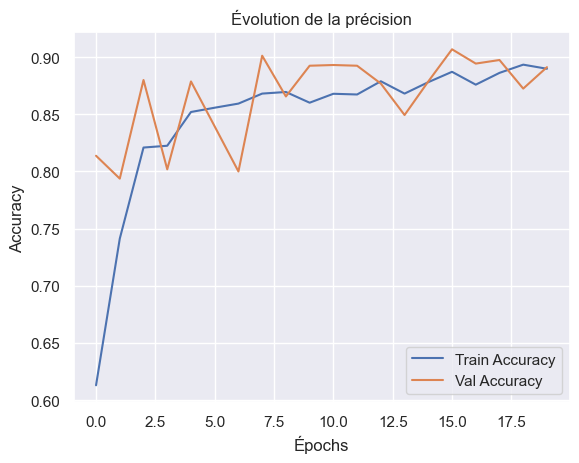

In [128]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Évolution de la précision')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("precision.png",dpi=120)
plt.show()

In [117]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


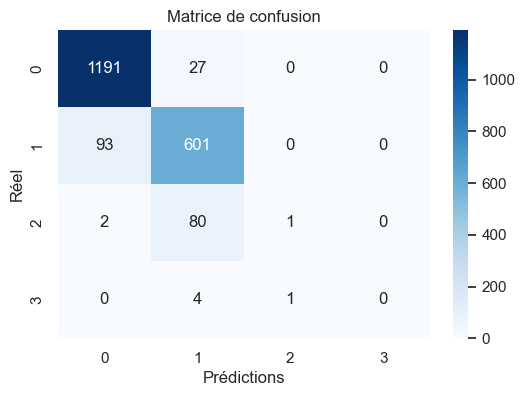

In [127]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.savefig("Confusion.png",dpi=120)
plt.show()

In [121]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["None", "Mild", "Moderate", "Severe"]))

              precision    recall  f1-score   support

        None       0.93      0.98      0.95      1218
        Mild       0.84      0.87      0.85       694
    Moderate       0.50      0.01      0.02        83
      Severe       0.00      0.00      0.00         5

    accuracy                           0.90      2000
   macro avg       0.57      0.46      0.46      2000
weighted avg       0.88      0.90      0.88      2000



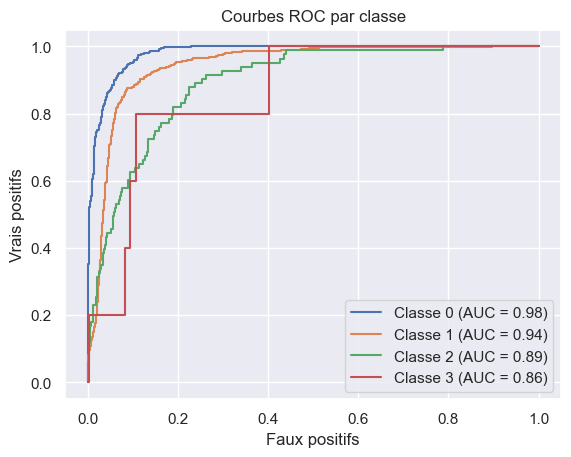

In [125]:
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')

plt.title("Courbes ROC par classe")
plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.legend()
plt.savefig("ROC.png",dpi=120)
plt.show()

In [129]:
#Classification si les classes sont bien représentées et bien prédites
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=5, n_informative=2, n_redundant=0,
                           n_classes=4, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# On entraine le MLP
model = MLPClassifier(hidden_layer_sizes=(50,30,10), max_iter=500, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df_plot = pd.DataFrame({
    "Feature1": X_test[:, 0],
    "Feature2": X_test[:, 1],
    "Prédiction": y_pred,
    "Réel": y_test
})

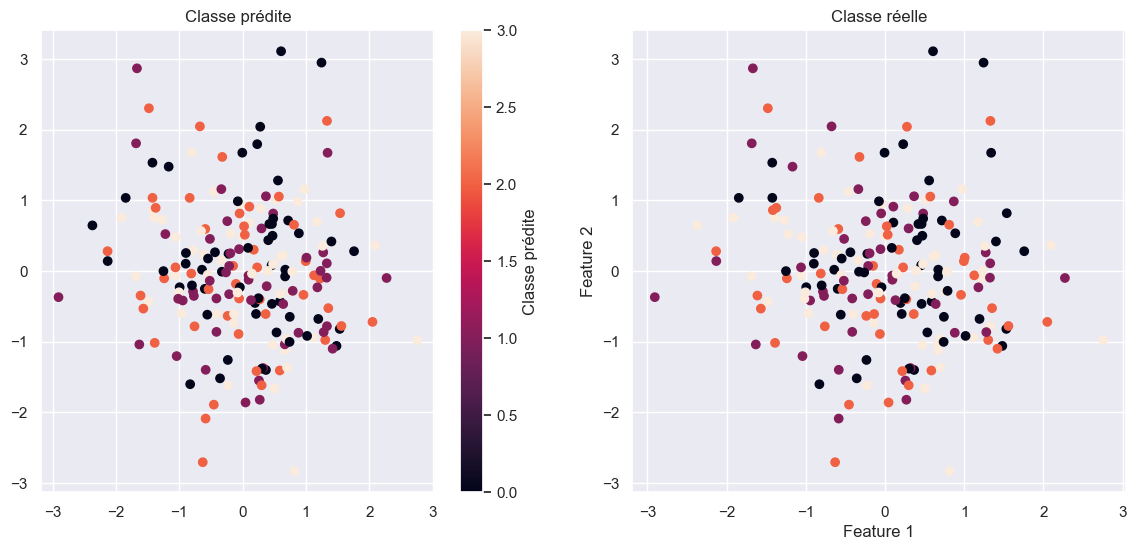

In [130]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14, 6))
scatter1 = ax1.scatter(df_plot["Feature1"], df_plot["Feature2"], c=df_plot["Prédiction"])
scatter2 = ax2.scatter(df_plot["Feature1"], df_plot["Feature2"], c=df_plot["Réel"])
ax1.set_title("Classe prédite")
ax2.set_title("Classe réelle")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter1,label="Classe prédite")
plt.savefig("Classe.png",dpi=120)
plt.show()

In [75]:
from tensorflow.keras.optimizers import Adam

def objectif2(essais):
    couche_cachee_1 = essais.suggest_int('couche_cachee_1', 32, 128)
    couche_cachee_2 = essais.suggest_int('couche_cachee_2', 16, 64)
    learning_rate = essais.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(couche_cachee_1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(couche_cachee_2, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    opti = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opti, metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    return val_acc

In [76]:
study = optuna.create_study(direction='maximize')
study.optimize(objectif2, n_trials=10)
print("Meilleurs hyperparamètres :", study.best_params)

[I 2025-12-09 20:35:27,134] A new study created in memory with name: no-name-4a096380-08d3-4ed9-8a76-a9c1bd74f1d3
[I 2025-12-09 20:35:31,371] Trial 0 finished with value: 0.84375 and parameters: {'couche_cachee_1': 44, 'couche_cachee_2': 47, 'learning_rate': 0.00026604218713066526}. Best is trial 0 with value: 0.84375.
[I 2025-12-09 20:35:36,134] Trial 1 finished with value: 0.856249988079071 and parameters: {'couche_cachee_1': 128, 'couche_cachee_2': 23, 'learning_rate': 0.0004200159945309912}. Best is trial 1 with value: 0.856249988079071.
[I 2025-12-09 20:35:40,529] Trial 2 finished with value: 0.875 and parameters: {'couche_cachee_1': 37, 'couche_cachee_2': 16, 'learning_rate': 0.0021230539457223487}. Best is trial 2 with value: 0.875.
[I 2025-12-09 20:35:44,621] Trial 3 finished with value: 0.875 and parameters: {'couche_cachee_1': 92, 'couche_cachee_2': 46, 'learning_rate': 0.0009531682785287339}. Best is trial 2 with value: 0.875.
[I 2025-12-09 20:35:48,801] Trial 4 finished wit

Meilleurs hyperparamètres : {'couche_cachee_1': 112, 'couche_cachee_2': 28, 'learning_rate': 0.007722952564697013}


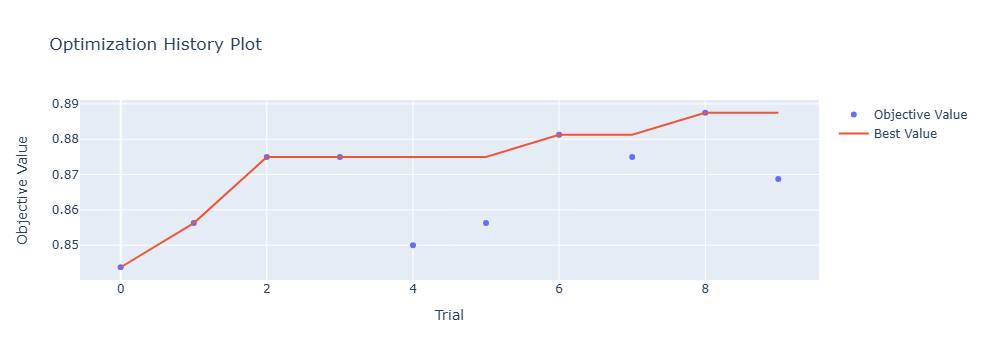

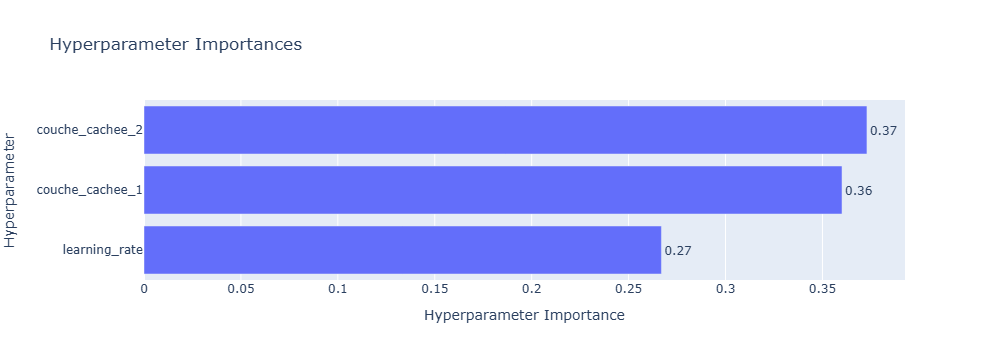

In [132]:
from optuna.visualization import plot_optimization_history, plot_param_importances
fig1 = plot_optimization_history(study)
fig1.show()

fig2 = plot_param_importances(study)
fig2.show()